# Preprocessing

In [1]:
import numpy as np
import pandas as pd
import matplotlib as plt
import pickle
import datetime
import copy

In [2]:
dataset_folder = "D:/datasets/genres"
fma_folder = dataset_folder + "/fma"
gtzan_folder = dataset_folder + "/gtzan"

In [3]:
# Load splits sets

def load_dataset(folder):
    train = pd.read_csv(folder + "/train.csv", index_col = 0)
    test = pd.read_csv(folder + "/test.csv", index_col = 0)
    return train, test

# FMA_train, FMA_test = load_dataset(fma_folder)
GTZAN_train, GTZAN_test = load_dataset(gtzan_folder)

# Check data was loaded correctly

# print(FMA_train.shape) # (16,060 X 137)
# print(FMA_test.shape) # (4,015 X 137)
print(GTZAN_train.shape) # (800, 137)
print(GTZAN_test.shape) # (200, 137)

from sklearn.preprocessing import StandardScaler, LabelEncoder

scaler = StandardScaler()

def prepare_dataset(scaler, labeler, dataset):
    y = labeler.fit_transform(dataset.pop("genre"))
    X = scaler.fit_transform(dataset)
    return y, X

GTZAN_labeler = LabelEncoder()
GTZAN_y, GTZAN_X = prepare_dataset(scaler, GTZAN_labeler, GTZAN_train)
GTZAN_y_test, GTZAN_X_test = prepare_dataset(scaler, GTZAN_labeler, GTZAN_test)

# FMA_labeler = LabelEncoder()
# FMA_y, FMA_X = prepare_dataset(scaler, FMA_labeler, FMA_train)

(800, 137)
(200, 137)


# Training

In [4]:
from thundersvm import SVC as gpuSVC
from sklearn.svm import SVC as cpuSVC
from sklearn.model_selection import GridSearchCV
from sklearn.utils import resample
import datetime

In [5]:
# bootstrapping

GTZAN_trials = 100
params = {'C' : [0.1, 1, 10, 100], 'gamma' : [0.0001, 0.001, 0.01, 0.1]}
models = []
start_time = datetime.datetime.now() 
for i in range(GTZAN_trials):
    a = datetime.datetime.now()
    X, y = resample(GTZAN_X, GTZAN_y)
    SVC = cpuSVC()
    CV = GridSearchCV(SVC, params, n_jobs = -1, cv = 5)
    CV.fit(X, y)
    print("trial:", i, str(datetime.datetime.now() - a), '\r', end='')
    models.append(CV)
end_time = datetime.datetime.now()
print("Elapsed Time: " + str(end_time - start_time))

Elapsed Time: 0:02:53.696461


In [9]:
# GTZAN without hierarchy or feature selection
start_time = datetime.datetime.now()

GTZAN_SVC1 = cpuSVC(gamma = 'scale')
params = {'C' : [0.1, 1, 10, 100], 'gamma' : [0.0001, 0.001, 0.01, 0.1]}

GTZAN_CV1 = GridSearchCV(GTZAN_SVC1, params, n_jobs = -1, cv = 5)
GTZAN_CV1.fit(GTZAN_X, GTZAN_y)

end_time = datetime.datetime.now()

print("Elapsed Time: " + str(end_time - start_time))

Elapsed Time: 0:00:00.842712


In [20]:
# FMA without hierarchy or feature selection

start_time = datetime.datetime.now() 

FMA_SVC1 = gpuSVC(cache_size=1000, n_jobs=1, shrinking=True, decision_function_shape='ovr')
params = {'C' : [0.0001, 0.001, 0.01, 0.1, 1, 10, 100]}

FMA_CV1 = GridSearchCV(FMA_SVC1, params, n_jobs = -1, cv = 5, scoring = 'f1_macro')
FMA_CV1.fit(FMA_X, FMA_y)

end_time = datetime.datetime.now()

print("Elapsed Time: " + str(end_time - start_time))

Elapsed Time: 0:03:57.504801


# Evaluation

In [10]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import datetime
import copy

In [55]:
accuracies = []
f1_scores = []
for model in models:
    predict = model.predict(GTZAN_X_test)
    accuracy = accuracy_score(GTZAN_y_test, predict)
    f1 = f1_score(GTZAN_y_test, predict, average = 'macro')
    accuracies.append(accuracy)
    f1_scores.append(f1)

In [46]:
# CIs using percentiles

confidence = 0.95

alpha = 100 - confidence * 100
lower_p = alpha / 2.0; higher_p = 100 - lower_p
print(np.percentile(accuracies, lower_p), np.median(accuracies), np.percentile(accuracies, higher_p))

0.60975 0.6625000000000001 0.7


In [47]:
# CIs using t distribution

import scipy
import math
confidence = 0.95

mean = np.mean(accuracies)
std = np.std(accuracies)
lo, hi = scipy.stats.t.interval(confidence, df = 99, loc=mean, scale=std)
print(lo, mean, hi)

0.6157333701112432 0.6607999999999999 0.7058666298887567


In [56]:
# CIs using norm distribution

import scipy
import math
confidence = 0.95

mean = np.mean(accuracies)
std = np.std(accuracies)
lo, hi = scipy.stats.norm.interval(confidence, loc=mean, scale=std)
print(lo, mean, hi)

0.6162842168748737 0.6607999999999999 0.7053157831251262


In [57]:
# CIs using binomial distribution

from math import sqrt
accuracy = 0.73
interval = 1.96 * sqrt((accuracy * (1-accuracy)) / 1000)
print(accuracy - interval, accuracy, accuracy + interval)

0.702483107733612 0.73 0.757516892266388


In [29]:
def display_cm(true, predict, classes, cmap = plt.cm.gray):
    cm = confusion_matrix(true, predict, labels = classes)
    
    row_sums = cm.sum(axis = 1, keepdims = True)
    norm_cm = cm / row_sums
    
    plt.imshow(norm_cm, cmap = cmap)

    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)

    plt.show()

0.73
0.7290559184076513


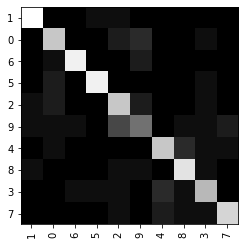

In [35]:
predict = GTZAN_CV1.predict(GTZAN_X_test)
print(accuracy_score(GTZAN_y_test, predict))
print(f1_score(GTZAN_y_test, predict, average = 'macro'))
display_cm(GTZAN_y_test, predict, pd.unique(GTZAN_y_test))